# Optimization towards a Perfect Entangler

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import weylchamber as wc
from weylchamber.visualize import WeylChamber
from weylchamber.coordinates import from_magic

%watermark -v --iversions

numpy            1.15.4
matplotlib.pylab 1.15.4
scipy            1.2.0
krotov           0.1.0.post1+dev
matplotlib       3.0.2
qutip            4.3.1
weylchamber      0.3.0
CPython 3.6.8
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

In this example, an optimization with an "unconventional" optimization target is demonstrated. Instead of a set of initial and target states or a certain target gate that should be implemented at final time, we rather just optimize for the closest perfectly entangling gate. See the following to references for details.

* P. Watts, et al., Phys. Rev. A 91, 062306 (2015)

* M. H. Goerz, et al., Phys. Rev. A 91, 062307 (2015)

## Define parameters

In [2]:
w1 = 1.1  # qubit 1 level splitting
w2 = 2.1  # qubit 2 level splitting
J = 0.2  # effective qubit coupling
u0 = 0.3  # initial driving strength
la = 1.1  # relative pulse coupling strength of second qubit
T = 25.0  # final time
nt = 250  # number of time steps

## Define the Hamiltonian

The system is a two-qubit system described by the effective Hamiltonian

\begin{equation}
  \op{H}(t) = - \frac{\omega_1}{2} \op{\sigma}_{z}^{(1)} - \frac{\omega_2}{2} \op{\sigma}_{z}^{(2)} + 2 J \left(\op{\sigma}_{x}^{(1)} \op{\sigma}_{x}^{(2)} + \op{\sigma}_{y}^{(1)} \op{\sigma}_{y}^{(2)}\right) + u(t) \left(\op{\sigma}_{x}^{(1)} + \lambda \op{\sigma}_{x}^{(2)}\right),
\end{equation}
where $\omega_1$ and $\omega_2$ are the energy level splitting of both qubits, respectively, $J$ is the effective coupling strength and $u(t)$ is the control field. $\lambda$ defines the relative pulse coupling between both qubits.

In [3]:
def ham_and_states(w1=w1, w2=w2, J=J, la=la, u0=u0):
    """Two qubit Hamiltonian

    Args:
        w1 (float): energy separation of the first qubit levels
        w2 (float): energy separation of the second qubit levels
        J (float): effective coupling between both qubits
        la (float): factor that pulse coupling strength differs for second qubit
        u0 (float): constant amplitude of the driving field
    """
    # local qubit Hamiltonians
    Hq1 = 0.5 * w1 * np.diag([-1, 1])
    Hq2 = 0.5 * w2 * np.diag([-1, 1])

    # lift Hamiltonians to joint system operators
    H0 = np.kron(Hq1, np.identity(2)) + np.kron(np.identity(2), Hq2)

    # define the interaction Hamiltonian
    sig_x = np.array([[0, 1], [1, 0]])
    sig_y = np.array([[0, -1j], [1j, 0]])
    Hint = 2 * J * (np.kron(sig_x, sig_x) + np.kron(sig_y, sig_y))
    H0 = H0 + Hint

    # define the drive Hamiltonian
    H1 = np.kron(np.array([[0, 1], [1, 0]]), np.identity(2)) + la * np.kron(
        np.identity(2), np.array([[0, 1], [1, 0]])
    )

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0)
    H1 = qutip.Qobj(H1)

    # canonical basis
    psi_00 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([1, 0])))
    psi_01 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([0, 1])))
    psi_10 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([1, 0])))
    psi_11 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([0, 1])))

    # define guess field
    eps0 = lambda t, args: u0
    return ([H0, [H1, eps0]], psi_00, psi_01, psi_10, psi_11)


H, psi_00, psi_01, psi_10, psi_11 = ham_and_states(
    w1=w1, w2=w2, J=J, la=la, u0=u0
)

In [4]:
proj_00 = psi_00 * psi_00.dag()
proj_01 = psi_01 * psi_01.dag()
proj_10 = psi_10 * psi_10.dag()
proj_11 = psi_11 * psi_11.dag()

## Define the optimization target

The time grid is given by `nt` equidistant
time steps between $t=0$ and $t=T$.

In [5]:
tlist = np.linspace(0, T, nt)

In order to specify the closest perfectly entangling gate as optimization target, we pass the canonical basis and specify `"PE"` as target gate.

In [6]:
objectives = krotov.gate_objectives(
    basis_states=[psi_00, psi_01, psi_10, psi_11], gate="PE", H=H
)

Furthermore, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end.

In [7]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T / 20, t_fall=T / 20, func='sinsq'
    )

Although the update-shape function $S(t)$ does not as such have any connection to the shape of the guess field, for convenience we also adopt it here as a pulse shape.

In [8]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args) * S(t)
    return eps0_shaped


H[1][1] = shape_field(H[1][1])

Before performing the optimization, we still have to choose `lambda_a`, which defines the control update magnitude in each iteration, and assign $S(t)$ to be used as shape function.

In [9]:
pulse_options = {H[1][1]: dict(lambda_a=1.0e2, shape=S)}

## Plot the guess field

In [10]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $u_{0}(t)$.

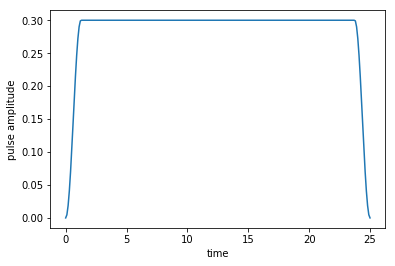

In [11]:
plot_pulse(H[1][1], tlist)

## Optimize

Our optimization target is the closest perfectly entangling gate, quantified by the perfect-entangler functional

\begin{equation}
  F_{PE} = g_3 \sqrt{g_1^2 + g_2^2} - g_1,
\end{equation}

where $g_1, g_2, g_3$ are the local invariants of the implemented gate, which uniquely identify its non-local content. As an alternative, one can also use the Weyl coordinates $c_1, c_2, c_3$ to plot the gate in the Weyl chamber. The perfectly entangling gates lie within a polyhedron within the general Weyl chamber and $F_{PE}$ becomes zero exactly at its boundaries.

In order to get feedback from the optimization, we define `print_fidelity`, which is called after each OCT step and which calculates $F_{PE}$ and the gate concurrence (as an alternative measure for the entangling power of quantum gates).



In [12]:
def print_fidelity(**args):
    basis = [objectives[i].initial_state for i in [0, 1, 2, 3]]
    states = [args['fw_states_T'][i] for i in [0, 1, 2, 3]]
    U = wc.gates.gate(basis, states)
    c1, c2, c3 = wc.coordinates.c1c2c3(from_magic(U))
    g1, g2, g3 = wc.local_invariants.g1g2g3_from_c1c2c3(c1, c2, c3)
    conc = wc.perfect_entanglers.concurrence(c1, c2, c3)
    F_PE = wc.perfect_entanglers.F_PE(g1, g2, g3)
    print(
        "    F_PE: %f\n    gate conc.: %f"
        % (F_PE, conc)
    )
    return F_PE, [c1, c2, c3]

Since Krotov's method needs to know how to calculate the so-called co-states, we must provide a callable function called `chi_constructor` to the optimization function `optimize_pulses`. This function returns

\begin{equation}
  \ket{\chi_{i}} = \frac{\partial F_{PE}}{\partial \bra{\phi_i}} \Bigg|_{\ket{\phi_{i}(T)}}
\end{equation}

for all $i$ and with $\ket{\phi_i(T)}$ a set of forward propagated Bell basis states. The required function is implemented in the package `weylchamber`, and is taken from there.

In [13]:
chi_constructor = wc.perfect_entanglers.make_PE_krotov_chi_constructor(
    [psi_00, psi_01, psi_10, psi_11]
)

As the perfect-entangler functional $F_{PE}$ depends strongly non-linearly on the states, Krotov's method formally requires the second-order contribution in order to guarantee monotonic convergence (see D. M. Reich, et al., J. Chem. Phys. 136, 104103 (2012) for details). In this case, the update formula can be extended and reads

\begin{split}
  \epsilon^{(i+1)}(t)
  & =
  \epsilon^{ref}(t) + \frac{S(t)}{\lambda_a} \Im \left\{
    \sum_{k=1}^{N}
    \Bigg\langle
      \chi_k^{(i)}(t)
    \Bigg\vert
    \left.\frac{\partial \Op{H}}{\partial \epsilon}\right\vert_{{\scriptsize \begin{matrix}\phi^{(i+1)}(t) \\\epsilon^{(i+1)}(t)\end{matrix}}}
    \Bigg\vert
    \phi_k^{(i+1)}(t)
    \Bigg\rangle
    \\
    +
    \frac{1}{2} \sigma(t)
    \Bigg\langle
      \Delta\phi_k(t)
      \Bigg\vert
              \left.\frac{\partial \Op{H}}{\partial \epsilon}\right\vert_{{\scriptsize \begin{matrix}\phi^{(i+1)}(t)\\\epsilon^{(i+1)}(t)\end{matrix}}}
      \Bigg\vert
      \phi_k^{(i+1)}(t)
     \Bigg\rangle
  \right\}\,,
\end{split}

where the latter term defines the second-order contribution. In order to evaluate the second-order term, we need to pass the scalar function $\sigma(t)$ to the optimizer `optimize_pulses`. We take

\begin{equation}
   \sigma(t) = -\max\left(\varepsilon_A,2A+\varepsilon_A\right)
\end{equation}

with $\varepsilon_A$ a small non-negative number, and $A$ a parameter that can be recalculated numerically after each iteration (see D. M. Reich, et al., J. Chem. Phys. 136, 104103 (2012) for details). The sigma function is expressed by subclassing `krotov.second_order.Sigma`, allowing us to connect the evaluation of the function $\sigma(t)$ and the recalculation of $A$:

In [14]:
class sigma(krotov.second_order.Sigma):
    def __init__(self, A, epsA=0):
        self.A = A
        self.epsA = epsA

    def __call__(self, t):
        ϵ, A = self.epsA, self.A
        return -max(ϵ, 2 * A + ϵ)

    def refresh(
        self,
        forward_states,
        forward_states0,
        chi_states,
        chi_norms,
        optimized_pulses,
        guess_pulses,
        objectives,
        result,
    ):
        try:
            Delta_J_T = result.info_vals[-1][0] - result.info_vals[-2][0]
        except IndexError:  # first iteration
            Delta_J_T = 0
        self.A = krotov.second_order.numerical_estimate_A(
            forward_states, forward_states0, chi_states, chi_norms, Delta_J_T
        )

In the following, we carry out the optimization and save the Weyl coordinates $c_1, c_2, c_3$ from each iteration

In [15]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chi_constructor,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information,
        print_fidelity,
    ),
    check_convergence=None,
    sigma=sigma(A=0.0),
    iter_stop=8,
)

Iteration 0
    objectives:
        1:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        2:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        3:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        4:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
    adjoint objectives:
        1:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        2:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        3:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        4:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
    S(t) (ranges): [0.000000, 1.000000]
    duration: 1.3 secs (started at 2019-02-12 14:15:25)
    optimized pulses (ranges): [0.00, 0.30]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 1.00e+02
    storage (bw, fw, fw0): None, [4 * ndarray(250)] (0.5 MB), [4 * ndarray(250)] (0.5 MB)
    fw_states_T norm: 1.000000, 1.000000, 1.000000, 1.000000
    F_PE: 1.447666
    gate conc.: 0.479571
Iteration 1
    duration: 4.7 secs (started at 2019-02-12 14:15:26)
    optimized pulses (ranges): [0

The following plots the path of the quantum gate within the Weyl chamber as a function of the iterations. As can be seen, the optimization drives the implemented gate towards the closest boundary of the polyhedron of perfect entanglers.

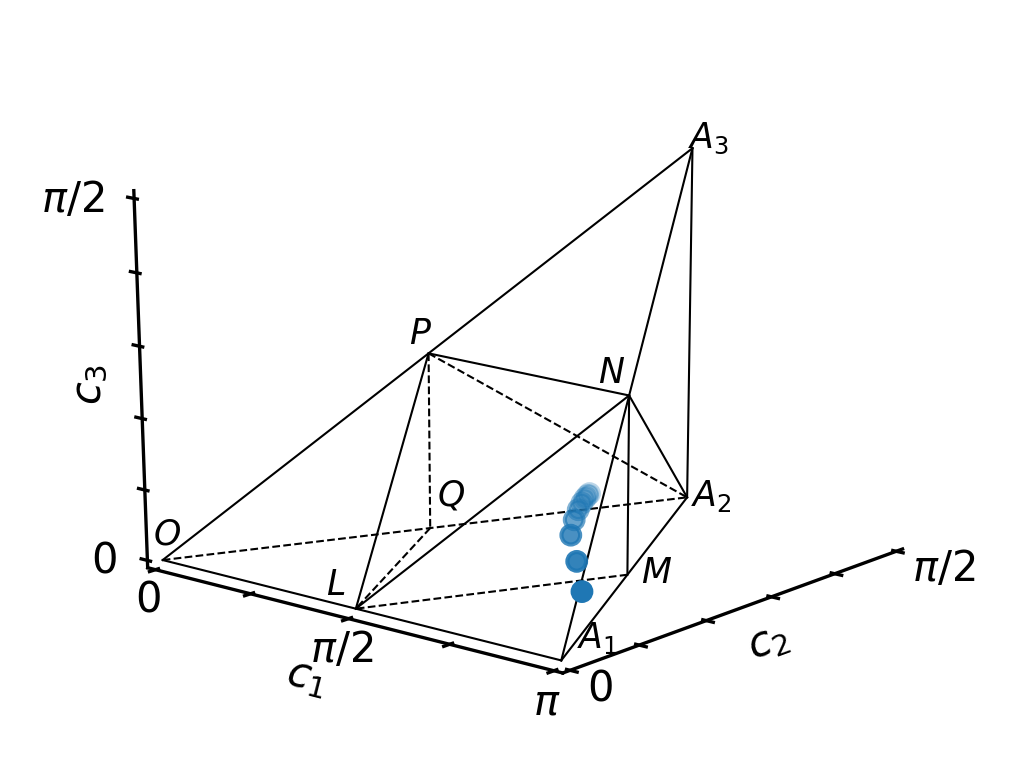

In [16]:
w = WeylChamber()
c1c2c3 = [oct_result.info_vals[i][1] for i in range(len(oct_result.iters))]
for i in range(len(oct_result.iters)):
    w.add_point(c1c2c3[i][0], c1c2c3[i][1], c1c2c3[i][2])
w.plot()

## Plot the optimized field

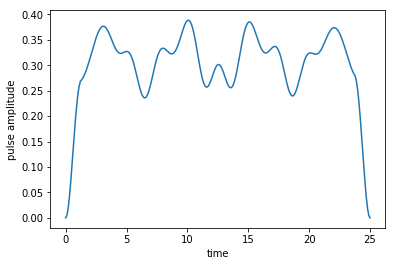

In [17]:
plot_pulse(oct_result.optimized_controls[0], tlist)